# Load Data

In [2]:
import tensorflow as tf

# Load the Fashion MNIST dataset
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Data Prep

In [3]:
train_filter = (y_train == 7) | (y_train == 9)
x_train_nn = x_train[train_filter]
y_train_nn = y_train[train_filter]

test_filter = (y_test == 7) | (y_test == 9)
x_test_nn = x_test[test_filter]
y_test_nn = y_test[test_filter]

print(y_train_nn)
y_train_nn_bin = (y_train_nn == 9).astype(int)
y_test_nn_bin = (y_test_nn == 9).astype(int)
print(y_train_nn_bin)

[9 7 9 ... 9 7 7]
[1 0 1 ... 1 0 0]


## Plot Data

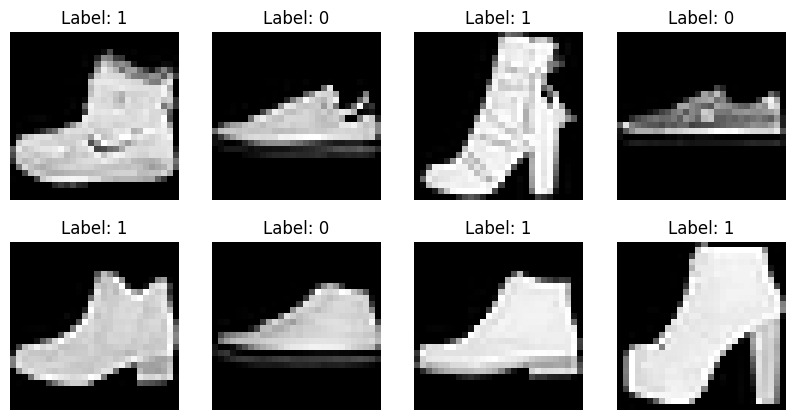

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_train_nn[i], cmap='gray')
    plt.title(f'Label: {y_train_nn_bin[i]}')
    plt.axis('off')

plt.show()

In [4]:
# Check the shape of the data
# Each image is 28 x 28 pixels
print(x_train_nn[1].shape)

(28, 28)


# CNN with Pytorth

## Design the Model

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.optim as optim

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## Data Prep

In [6]:
# Convert the data to PyTorch tensors
x_train_tensor = torch.tensor(x_train_nn.reshape(-1, 1, 28, 28), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_nn_bin, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_nn.reshape(-1, 1, 28, 28), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_nn_bin, dtype=torch.long)

# Create DataLoader for training and testing
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Fit the Model

In [7]:
# Initialize the model, loss function, and optimizer
t_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(t_model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    t_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = t_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate validation loss and accuracy
    t_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_inputs, val_labels in test_loader:
            val_outputs = t_model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            _, predicted = torch.max(val_outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    
    # Compute metrics
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = correct / total
    
    # Print metrics rounded to 4 decimals
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}')


Epoch 1/10, Train Loss: 0.1741, Validation Loss: 0.0991, Validation Accuracy: 0.9645
Epoch 2/10, Train Loss: 0.0939, Validation Loss: 0.0921, Validation Accuracy: 0.9665
Epoch 3/10, Train Loss: 0.0820, Validation Loss: 0.0789, Validation Accuracy: 0.9710
Epoch 4/10, Train Loss: 0.0746, Validation Loss: 0.0770, Validation Accuracy: 0.9690
Epoch 5/10, Train Loss: 0.0677, Validation Loss: 0.0802, Validation Accuracy: 0.9660
Epoch 6/10, Train Loss: 0.0665, Validation Loss: 0.0840, Validation Accuracy: 0.9710
Epoch 7/10, Train Loss: 0.0598, Validation Loss: 0.0744, Validation Accuracy: 0.9725
Epoch 8/10, Train Loss: 0.0560, Validation Loss: 0.0754, Validation Accuracy: 0.9730
Epoch 9/10, Train Loss: 0.0510, Validation Loss: 0.0702, Validation Accuracy: 0.9740
Epoch 10/10, Train Loss: 0.0458, Validation Loss: 0.0857, Validation Accuracy: 0.9690


## Plot Confusion Matrix

[[948  52]
 [ 10 990]]


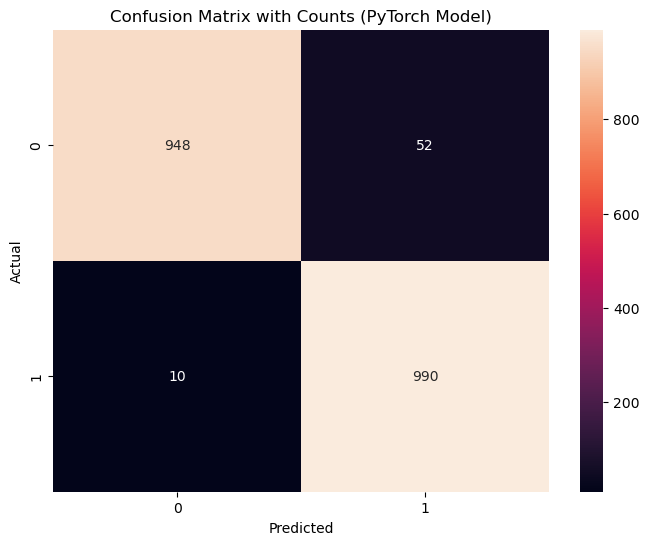

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
t_model.eval()
test_predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = t_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_predictions.extend(predicted.numpy())

# Convert predictions to numpy array
test_predictions = np.array(test_predictions)

# Compute the confusion matrix
conf_matrix_torch = confusion_matrix(y_test_nn_bin, test_predictions)

# Print the confusion matrix
print(conf_matrix_torch)

# Plot the confusion matrix with counts
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_torch, annot=True, fmt='d', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Counts (PyTorch Model)')
plt.show()

## Plot Misclassifications

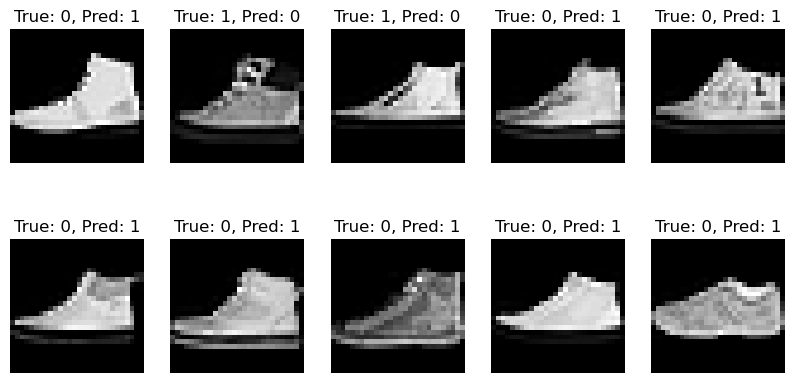

In [9]:
# Find the indices of misclassified samples
misclassified_indices_torch = [i for i in range(len(y_test_nn_bin)) if test_predictions[i] != y_test_nn_bin[i]]

plt.figure(figsize=(10, 5))

for i, idx in enumerate(misclassified_indices_torch[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_nn[idx], cmap='gray')
    plt.title(f'True: {y_test_nn_bin[idx]}, Pred: {test_predictions[idx]}')
    plt.axis('off')

plt.show()

# Data Transformations

## Horizontal Flip

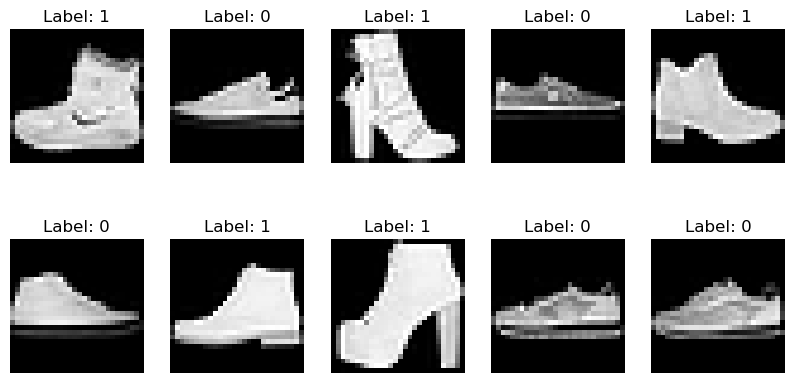

In [10]:
import random
import torchvision.transforms as transforms

# Define the transform to apply horizontal flip
horizontal_flip_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to apply the flip
    transforms.ToTensor()
])

# Apply the horizontal flip transform to the selected indices
x_train_nn_flipped = x_train_nn.copy()

for idx in range(len(x_train_nn_flipped)):
    x_train_nn_flipped[idx] = horizontal_flip_transform(x_train_nn_flipped[idx])

# Plot the first 10 images
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_nn_flipped[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {y_train_nn_bin[i]}')
    plt.axis('off')

plt.show()

## Shift

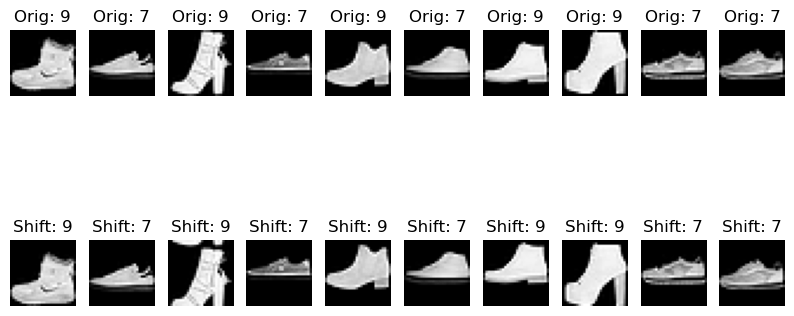

In [11]:
import numpy as np

import matplotlib.pyplot as plt

# Function to shift image pixels up or down
def shift_image(image, shift):
    return np.roll(image, shift, axis=0)

# Create a copy of the data
x_train_nn_shift = x_train_nn.copy()

# Apply the shift to each image
shifts = np.random.randint(-5, 6, size=x_train_nn.shape[0])
for i, shift in enumerate(shifts):
    x_train_nn_shift[i] = shift_image(x_train_nn[i], shift)

# Plot original images next to shifted images
plt.figure(figsize=(10, 5))

for i in range(10):
    # Plot original image
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_train_nn[i].reshape(28, 28), cmap='gray')
    plt.title(f'Orig: {y_train_nn[i]}')
    plt.axis('off')
    
    # Plot shifted image
    plt.subplot(2, 10, i + 11)
    plt.imshow(x_train_nn_shift[i].reshape(28, 28), cmap='gray')
    plt.title(f'Shift: {y_train_nn[i]}')
    plt.axis('off')

plt.show()

## Shift Black

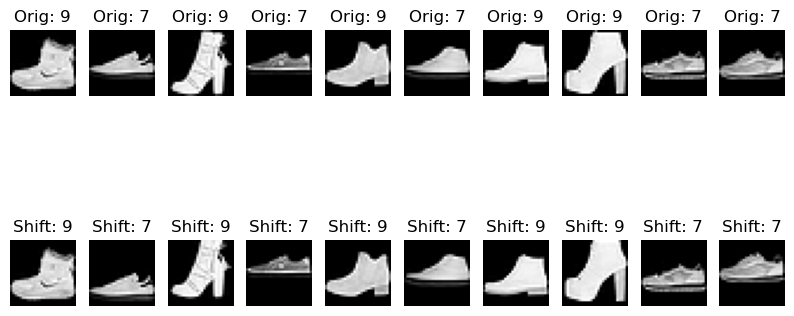

In [12]:
# Function to shift image pixels up or down and replace wrapped pixels with black pixels
def shift_image_black(image, shift):
    if shift > 0:
        image[shift:] = image[:-shift]
        image[:shift] = 0
    elif shift < 0:
        image[:shift] = image[-shift:]
        image[shift:] = 0
    return image

# Create a copy of the data
x_train_nn_shift_black = x_train_nn.copy()

# Apply the shift to each image
shifts = np.random.randint(-5, 6, size=x_train_nn.shape[0])
for i, shift in enumerate(shifts):
    x_train_nn_shift_black[i] = shift_image_black(x_train_nn_shift_black[i], shift)

# Plot original images next to shifted images
plt.figure(figsize=(10, 5))

for i in range(10):
    # Plot original image
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_train_nn[i].reshape(28, 28), cmap='gray')
    plt.title(f'Orig: {y_train_nn[i]}')
    plt.axis('off')
    
    # Plot shifted image
    plt.subplot(2, 10, i + 11)
    plt.imshow(x_train_nn_shift_black[i].reshape(28, 28), cmap='gray')
    plt.title(f'Shift: {y_train_nn[i]}')
    plt.axis('off')

plt.show()

## Rotate

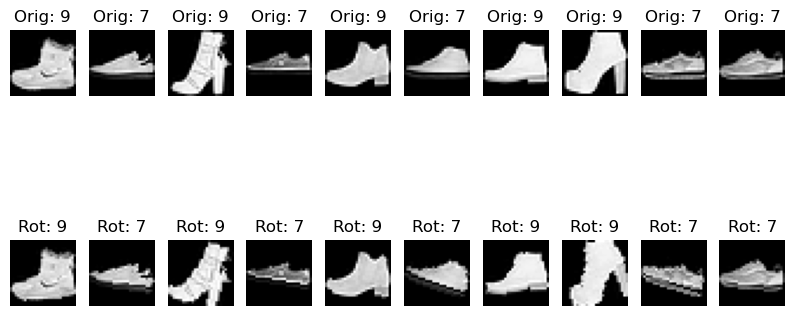

In [13]:
import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF

# Function to rotate image by a random angle
def random_rotate(image):
    # Convert NumPy array to PIL image
    pil_image = Image.fromarray((image * 255).astype(np.uint8))  # Ensure the image is scaled to 0-255 and cast to uint8
    # Apply random rotation
    angle = np.random.uniform(-20, 20)
    rotated_pil_image = TF.rotate(pil_image, angle)
    # Convert back to NumPy array and normalize to the original range (e.g., 0-1 if originally normalized)
    return np.array(rotated_pil_image) / 255.0  # Scale back to 0-1 range if necessary

# Create a copy of the data
x_train_nn_rotate = x_train_nn.copy()

# Apply the random rotation to each image
for i in range(x_train_nn_rotate.shape[0]):
    x_train_nn_rotate[i] = random_rotate(x_train_nn_rotate[i])

# Plot original images next to rotated images
plt.figure(figsize=(10, 5))

for i in range(10):
    # Plot original image
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_train_nn[i].reshape(28, 28), cmap='gray')
    plt.title(f'Orig: {y_train_nn[i]}')
    plt.axis('off')
    
    # Plot rotated image
    plt.subplot(2, 10, i + 11)
    plt.imshow(x_train_nn_rotate[i].reshape(28, 28), cmap='gray')
    plt.title(f'Rot: {y_train_nn[i]}')
    plt.axis('off')

plt.show()

## Combine Transformations

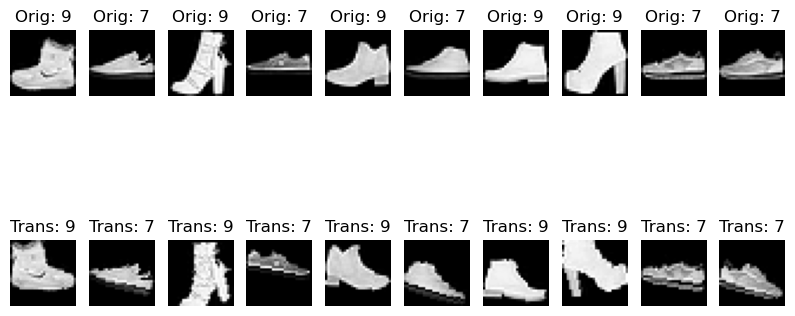

In [14]:
import random
import numpy as np
from PIL import Image

import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Define the combined transform function
def combined_transform(image):
    # Convert NumPy array to PIL image
    pil_image = Image.fromarray((image * 255).astype(np.uint8))  # Ensure the image is scaled to 0-255 and cast to uint8
    
    # Apply horizontal flip with 50% probability
    if random.random() > 0.5:
        pil_image = TF.hflip(pil_image)
    
    # Apply random rotation
    angle = np.random.uniform(-20, 20)
    pil_image = TF.rotate(pil_image, angle)
    
    # Convert back to NumPy array and normalize to the original range (e.g., 0-1 if originally normalized)
    image = np.array(pil_image) / 255.0  # Scale back to 0-1 range if necessary
    
    # Apply random vertical shift
    shift = np.random.randint(-5, 6)
    if shift > 0:
        image[shift:] = image[:-shift]
        image[:shift] = 0
    elif shift < 0:
        image[:shift] = image[-shift:]
        image[shift:] = 0
    
    return image

# Create a copy of the data
x_train_nn_transformed = x_train_nn.copy()

# Apply the combined transform to each image
for i in range(x_train_nn_transformed.shape[0]):
    x_train_nn_transformed[i] = combined_transform(x_train_nn_transformed[i])

# Plot original images next to transformed images
plt.figure(figsize=(10, 5))

for i in range(10):
    # Plot original image
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_train_nn[i].reshape(28, 28), cmap='gray')
    plt.title(f'Orig: {y_train_nn[i]}')
    plt.axis('off')
    
    # Plot transformed image
    plt.subplot(2, 10, i + 11)
    plt.imshow(x_train_nn_transformed[i].reshape(28, 28), cmap='gray')
    plt.title(f'Trans: {y_train_nn[i]}')
    plt.axis('off')

plt.show()

## Data Transformations

torch.Size([64, 1, 28, 28]) torch.Size([64])


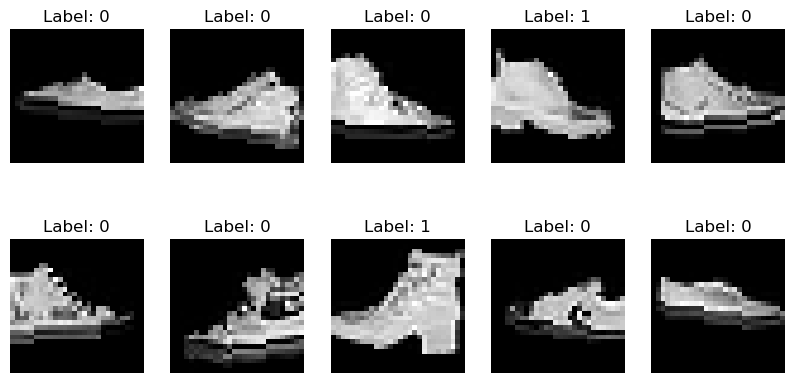

In [22]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

# Define data augmentation transformations
train_mod = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),   # Flip 50% of images
    transforms.RandomRotation(degrees=10),    # Rotate within ±10 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    
    transforms.ToTensor(),                     # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))       # Normalize to [-1, 1]
])

# Define data augmentation transformations
test_mod = transforms.Compose([
    transforms.ToTensor(),                     # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))       # Normalize to [-1, 1]
])

# Load the training dataset with augmentation
train_dataset = FashionMNIST(root="./data", train=True, transform=train_mod, download=True)

# Filter the dataset to include only 7s and 9s
train_indices = (train_dataset.targets == 7) | (train_dataset.targets == 9)
train_dataset.targets = train_dataset.targets[train_indices]
train_dataset.data = train_dataset.data[train_indices]

# Convert labels to binary (0 for 7s and 1 for 9s)
train_dataset.targets = (train_dataset.targets == 9).long()

# Create DataLoader
train_loader_mod = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Load Fashion MNIST test dataset
test_dataset = FashionMNIST(root="./data", train=False, transform=test_mod, download=True)

# Filter the dataset to include only 7s and 9s
test_indices = (test_dataset.targets == 7) | (test_dataset.targets == 9)
test_dataset.targets = test_dataset.targets[test_indices]
test_dataset.data = test_dataset.data[test_indices]

# Convert labels to binary (0 for 7s and 1 for 9s)
test_dataset.targets = (test_dataset.targets == 9).long()

# Create DataLoader
test_loader_mod = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Iterate over batches
for images, labels in train_loader_mod:
    # images now contain dynamically augmented data
    print(images.shape, labels.shape)
    break  # Checking one batch

# Plot some of the transformed images
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')

plt.show()

### Fit the CNN

In [17]:
# Initialize the model, loss function, and optimizer
t_model3 = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(t_model3.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    t_model3.train()
    running_loss = 0.0
    for inputs, labels in train_loader_mod:
        optimizer.zero_grad()
        outputs = t_model3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate validation loss and accuracy
    t_model3.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_inputs, val_labels in test_loader_mod:
            val_outputs = t_model3(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            _, predicted = torch.max(val_outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    
    # Compute metrics
    avg_train_loss = running_loss / len(train_loader_mod)
    avg_val_loss = val_loss / len(test_loader_mod)
    val_accuracy = correct / total
    
    # Print metrics rounded to 4 decimals
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}')

Epoch 1/10, Train Loss: 0.2260, Validation Loss: 0.1448, Validation Accuracy: 0.9405
Epoch 2/10, Train Loss: 0.1697, Validation Loss: 0.1081, Validation Accuracy: 0.9580
Epoch 3/10, Train Loss: 0.1392, Validation Loss: 0.1047, Validation Accuracy: 0.9645
Epoch 4/10, Train Loss: 0.1251, Validation Loss: 0.0921, Validation Accuracy: 0.9645
Epoch 5/10, Train Loss: 0.1200, Validation Loss: 0.0925, Validation Accuracy: 0.9615
Epoch 6/10, Train Loss: 0.1123, Validation Loss: 0.0906, Validation Accuracy: 0.9640
Epoch 7/10, Train Loss: 0.1138, Validation Loss: 0.0855, Validation Accuracy: 0.9675
Epoch 8/10, Train Loss: 0.1084, Validation Loss: 0.0889, Validation Accuracy: 0.9675
Epoch 9/10, Train Loss: 0.0975, Validation Loss: 0.0801, Validation Accuracy: 0.9695
Epoch 10/10, Train Loss: 0.1004, Validation Loss: 0.0841, Validation Accuracy: 0.9695
